In [2]:
#https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2
! pip install transformers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

     |████████████████████████████████| 2.3MB 3.8MB/s 
     |████████████████████████████████| 3.3MB 40.3MB/s 
     |████████████████████████████████| 901kB 44.5MB/s 


In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 4.6.1


#🎬 The example task

The chosen task is a multi-class text classification on Movie Reviews.

For each text movie review, the model has to predict a label for the sentiment. We evaluate the outputs of the model on classification accuracy. The sentiment labels are:

- 0 → Negative
- 1 → Somewhat negative
- 2 → Neutral
- 3 → Somewhat positive
- 4 → Positive

The data is loaded into a DataFrame using pandas.

In [4]:
pwd

'/content'

In [5]:
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/test.tsv.zip
/content/sampleSubmission.csv
/content/train.tsv.zip
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/gce
/content/.config/config_sentinel
/content/.config/active_config
/content/.config/configurations/config_default
/content/.config/logs/2021.06.01/13.40.26.776675.log
/content/.config/logs/2021.06.01/13.40.21.024150.log
/content/.config/logs/2021.06.01/13.40.05.370650.log
/content/.config/logs/2021.06.01/13.40.44.102103.log
/content/.config/logs/2021.06.01/13.40.43.432793.log
/content/.config/logs/2021.06.01/13.39.46.598129.log
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_train.csv


In [6]:
DATA_ROOT = Path("..") / "/content"
train = pd.read_csv(DATA_ROOT / 'train.tsv.zip', sep="\t")
test = pd.read_csv(DATA_ROOT / 'test.tsv.zip', sep="\t")
print(train.shape,test.shape)
train.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


It is worth noting that in the dataset there are no individual movie reviews but rather phrases taken out of context and split into smaller parts, each with an assigned sentiment label.

#Main transformers classes
In transformers, each model architecture is associated with 3 main types of classes:

- A model class to load/store a particular pre-train model.
- A tokenizer class to pre-process the data and make it compatible with a particular model.
- A configuration class to load/store the configuration of a particular model.

For example, if you want to use the Bert architecture for text classification, you would use BertForSequenceClassification for the model class, BertTokenizer for the tokenizer class and BertConfig for the configuration class. 

In order to switch easily between classes  -  each related to a specific model type  -  I created a dictionary that allows loading the correct classes by just specifying the correct model type name.

In [7]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

You will see later, that those classes share a common class method from_pretrained(pretrained_model_name, ...). In our case, the parameter pretrained_model_name is a string with the shortcut name of a pre-trained model/tokenizer/configuration to load, e.g 'bert-base-uncased'. We can find all the shortcut names in the transformers documentation [here](https://huggingface.co/transformers/pretrained_models.html#pretrained-models).

In [8]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

#model_type = 'roberta'
#pretrained_model_name = 'distilbert'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [9]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

Print the available values for pretrained_model_name (shortcut names) corresponding to the model_type used.

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

It is worth noting that in this case, we use the transformers library only for a multi-class text classification task. For that reason, this tutorial integrates only the transformer architectures that have a model for sequence classification implemented. These model types are :

- BERT (from Google)
- XLNet (from Google/CMU)
- XLM (from Facebook)
- RoBERTa (from Facebook)
- DistilBERT (from HuggingFace)



#Util function

In [10]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [11]:
seed_all(seed)

#Data pre-processing

To match pre-training, we have to format the model input sequence in a specific format. To do so, you have to first tokenize and then numericalize the texts correctly. The difficulty here is that each pre-trained model, that we will fine-tune, requires exactly the same specific pre-process - tokenization & numericalization - than the pre-process used during the pre-train part. Fortunately, the tokenizer class from transformers provides the correct pre-process tools that correspond to each pre-trained model.

In the fastai library, data pre-processing is done automatically during the creation of the DataBunch. As you will see in the DataBunch implementation, the tokenizer and numericalizer are passed in the processor argument under the following format :

processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]

Let's first analyse how we can integrate the transformers tokenizer within the TokenizeProcessor function.

#Custom Tokenizer
This part can be a little bit confusing because a lot of classes are wrapped in each other and with similar names. To resume, if we look attentively at the fastai implementation, we notice that :

- The TokenizeProcessor object takes as tokenizer argument a Tokenizer object.
- The Tokenizer object takes as tok_func argument a BaseTokenizer object.
- The BaseTokenizer object implement the function tokenizer(t:str) → List[str] that take a text t and returns the list of its tokens.

Therefore, we can simply create a new class TransformersBaseTokenizer that inherits from BaseTokenizer and overwrite a new tokenizer function.

In [12]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.model_max_length
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1- As we are not using RNN, we have to limit the sequence length to the model input size.

2- Most of the models require special tokens placed at the beginning and end of the sequences.

3- Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the HuggingFace documentation in each model section.

bert:       [CLS] + tokens + [SEP] + padding

roberta:    [CLS] + prefix_space + tokens + [SEP] + padding

distilbert: [CLS] + tokens + [SEP] + padding

xlm:        [CLS] + tokens + [SEP] + padding

xlnet:      padding + tokens + [SEP] + [CLS]

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the DataBunch.

#Custom Numericalizer
In fastai, NumericalizeProcessor object takes as vocab argument a Vocab object. From this analyse, we suggest two ways to adapt the fastai numericalizer:

- You can, like decribed in the Dev Sharma's article (Section 1. Setting Up the Tokenizer), retreive the list of tokens and create a Vocab object.

- Create a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions.

Even if the first solution seems to be simpler, Transformers does not provide, for all models, a straightforward way to retreive his list of tokens. Therefore, I implemented the second solution, which runs for each model type. It consists of using the functions convert_tokens_to_ids and convert_ids_to_tokens in respectively numericalize and textify.

In [14]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

NB: The functions __getstate__ and __setstate__ allow the functions export and load_learner to work correctly with TransformersVocab.

#Custom processor
Now that we have our custom tokenizer and numericalizer, we can create the custom processor. Notice we are passing the include_bos = False and include_eos = False options. This is because fastai adds its own special tokens by default which interferes with the [CLS] and [SEP] tokens added by our custom tokenizer.

In [15]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

#Setting up the Databunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor transformer_processor and manage correctly the padding.

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']
[16183, 4904, 1039, 9765, 25175, 1010, 7592, 2009, 1055, 2033]


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

There is multible ways to create a DataBunch, in our implementation, we use the data block API, which gives more flexibility

In [18]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Check batch and tokenizer :

In [19]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"[CLS] - l ##rb - city - rr ##b - reminds us how realistic ##ally nu ##ance ##d a robert de ni ##ro performance can be when he is not more lucrative ##ly engaged in the shame ##less self - car ##ica ##ture of ` analyze this ' - l ##rb - 1999 - rr ##b - and ` analyze that , ' promised - l ##rb - or threatened",3
"[CLS] the real triumph ##s in i ##gb ##y come from philippe , who makes oliver far more interesting than the character ' s lines would suggest , and sara ##ndon , who could n ' t be better as a cruel but weird ##ly li ##ka ##ble wasp mat ##ron . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",3
"[CLS] parker should be commended for taking a fresh approach to familiar material , but his determination to remain true to the original text leads him to adopt a somewhat manner ##ed tone . . . that ultimately dull ##s the human tragedy at the story ' s core [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",2
"[CLS] it ' s a long way from or ##well ' s dark , intelligent warning cry - l ##rb - 1984 - rr ##b - to the empty stud knock ##ab ##out of equilibrium , and what once was conviction is now affect ##ation . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",1
"[CLS] a different and emotionally reserved type of survival story - - a film less about ref ##rac ##ting all of world war ii through the specific conditions of one man , and more about that man lost in its midst . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",3


Check batch and numericalizer :

In [20]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([16, 80])
tensor([[ 101, 1011, 1048,  ..., 2095, 1012,  102],
        [ 101, 2031, 2000,  ...,    0,    0,    0],
        [ 101, 2065, 2017,  ...,    0,    0,    0],
        ...,
        [ 101, 1005, 1055,  ...,    0,    0,    0],
        [ 101, 2004, 2035,  ...,    0,    0,    0],
        [ 101, 3904, 1997,  ...,    0,    0,    0]])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


#Custom model
As mentioned here, every model's forward method always outputs a tuple with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits.  One way to access them is to create a custom model.

In [21]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels. To do so, you can modify the config instance or either modify like in Keita Kurita's article (Section: Initializing the Learner) the num_labels argument.

In [22]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.6.1",
  "vocab_size": 30522
}



In [23]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

#Learner : Custom Optimizer / Custom Metric
In pytorch-transformers, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer. This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within fastai. It is worth noting that for reproducing BertAdam specific behavior, you have to set correct_bias = False.

In [24]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

#Discriminative Fine-tuning and Gradual unfreezing (Optional)
To use discriminative layer training and gradual unfreezing, fastai provides one tool that allows to "split" the structure model into groups. An instruction to perform that "split" is described in the fastai documentation [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training).

Unfortunately, the model architectures are too different to create a unique generic function that can "split" all the model types in a convenient way. Thereby, you will have to implement a custom "split" for each different model architecture.

For example, if we use the RobBERTa model and that we observe his architecture by making print(learner.model).

In [25]:
print(learner.model)

CustomTransformerModel(
  (transformer): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

We can decide to divide the model in 14 blocks :

- 1 Embedding
- 12 transformer
- 1 classifier

In this case, we can split our model in this way :

In [26]:
# For DistilBERT
list_layers = [learner.model.transformer.distilbert.embeddings,
                learner.model.transformer.distilbert.transformer.layer[0],
                learner.model.transformer.distilbert.transformer.layer[1],
                learner.model.transformer.distilbert.transformer.layer[2],
                learner.model.transformer.distilbert.transformer.layer[3],
                learner.model.transformer.distilbert.transformer.layer[4],
                learner.model.transformer.distilbert.transformer.layer[5],
                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
'''list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]'''

'list_layers = [learner.model.transformer.roberta.embeddings,\n              learner.model.transformer.roberta.encoder.layer[0],\n              learner.model.transformer.roberta.encoder.layer[1],\n              learner.model.transformer.roberta.encoder.layer[2],\n              learner.model.transformer.roberta.encoder.layer[3],\n              learner.model.transformer.roberta.encoder.layer[4],\n              learner.model.transformer.roberta.encoder.layer[5],\n              learner.model.transformer.roberta.encoder.layer[6],\n              learner.model.transformer.roberta.encoder.layer[7],\n              learner.model.transformer.roberta.encoder.layer[8],\n              learner.model.transformer.roberta.encoder.layer[9],\n              learner.model.transformer.roberta.encoder.layer[10],\n              learner.model.transformer.roberta.encoder.layer[11],\n              learner.model.transformer.roberta.pooler]'

Check groups :

In [27]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 8 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (3): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768

Note that I didn't found any document that has studied the influence of Discriminative Fine-tuning and Gradual unfreezing or even Slanted Triangular Learning Rates with transformers. Therefore, using these tools does not guarantee better results. If you found any interesting documents, please let us know in the comment.

#Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use Slanted Triangular Learning Rates, Discriminate Learning Rate and gradually unfreeze the model.

In [28]:
learner.save('untrain')

In [29]:
seed_all(seed)
learner.load('untrain');

In [30]:
#Therefore, we first freeze all the groups but the classifier with:
learner.freeze_to(-1) 

In [31]:
#We check which layer are trainable.
learner.summary()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [80, 768]            23,440,896 False     
______________________________________________________________________
Embedding            [80, 768]            393,216    False     
______________________________________________________________________
LayerNorm            [80, 768]            1,536      False     
______________________________________________________________________
Dropout              [80, 768]            0          False     
______________________________________________________________________
Dropout              [12, 80, 80]         0          False     
______________________________________________________________________
Linear               [80, 768]            590,592    False     
______________________________________________________________________
Linear               [80, 768]            590,592    False     
_______________________________________

For Slanted Triangular Learning Rates you have to use the function one_cycle. For more information please check the fastai documentation [here](https://https://docs.fast.ai/callbacks.one_cycle.html). 

To use our one_cycle we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using lr_find.

In [32]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-01
Min loss divided by 10: 4.37E-04


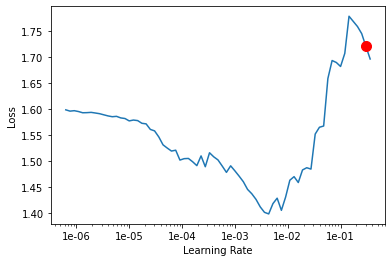

In [33]:
learner.recorder.plot(skip_end=10,suggestion=True)

We will pick a value a bit before the minimum, where the loss still improves. Here 2x10^-2 seems to be a good value.

Next we will use fit_one_cycle with the chosen learning rate as the maximum learning rate.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.008529,0.971649,0.583109,0.416891,1:00:48


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


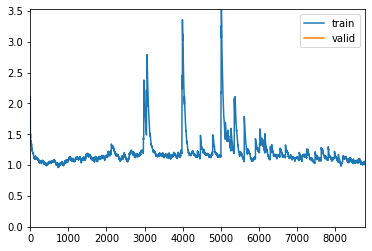

In [34]:
learner.fit_one_cycle(1,max_lr=2e-02,moms=(0.8,0.7))

In [35]:
learner.save('first_cycle')

In [36]:
seed_all(seed)
learner.load('first_cycle');

In [37]:
#We then unfreeze the second group of layers and repeat the operations.
learner.freeze_to(-2)
lr = 1e-4

Note here that we use slice to create separate learning rate for each group.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.836054,0.832514,0.654171,0.345829,1:26:48


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


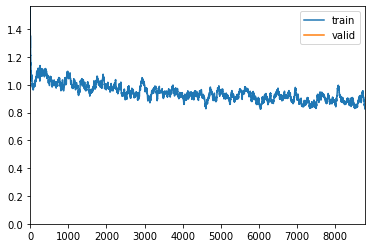

In [38]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [39]:
learner.save('second_cycle')

In [40]:
seed_all(seed)
learner.load('second_cycle');

In [41]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.773789,0.775329,0.677240,0.322760,1:52:00


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


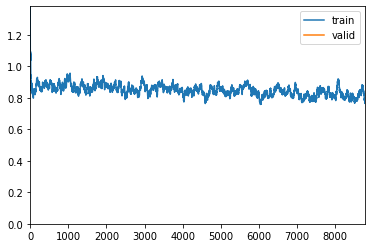

In [42]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [43]:
learner.save('third_cycle')

In [44]:
seed_all(seed)
learner.load('third_cycle');


Here, we unfreeze all the groups.

In [45]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.756045,0.775153,0.675445,0.324555,4:32:29


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


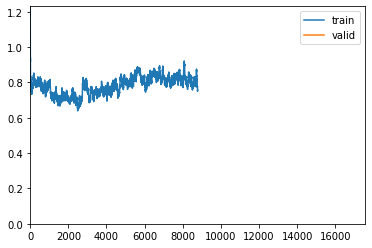

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

Now, you can predict examples with:

In [ ]:
learner.predict('This is the best movie of 2020')

In [ ]:
learner.predict('This is the worst movie of 2020')

#Conclusion
In this NoteBook, I explain how to combine the transformers library with the beloved fastai library. It aims to make you understand where to look and modify both libraries to make them work together. Likely, it allows you to use Slanted Triangular Learning Rates, Discriminate Learning Rate and even Gradual Unfreezing. As a result, without even tunning the parameters, you can obtain rapidly state-of-the-art results.

This year, the transformers became an essential tool to NLP. Because of that, I think that pre-trained transformers architectures will be integrated soon to future versions of fastai. Meanwhile, this tutorial is a good starter.

I hope you enjoyed this first article and found it useful.  Thanks for reading and don't hesitate in leaving questions or suggestions.